## 1. 자막파일 텍스트만 추출

In [ ]:
import pandas as pd
data = pd.read_csv('crawling_data_raw.csv', delimiter=';')

import re

def srt_to_strings(caption_strings):
    regex_list = []
    re_pattern = r'[0-9]+\n[0-9]{2}:[0-9]{2}:[0-9]{2},[0-9]{3} --> [0-9]{2}:[0-9]{2}:[0-9]{2},[0-9]{3}\n'
    for caption_string in caption_strings:
        if caption_string == None:
            continue
        sub = str(caption_string)
        string_list = re.compile(re_pattern).split(sub)
        regex_list.extend(string_list)
    
    return regex_list

sentences = srt_to_strings(data['caption'])
sentences = pd.DataFrame(sentences)
sentences.columns = ['sentence']

sentences = sentences['sentence'].str.replace("\n", "")


sentences = sentences.to_frame()


In [ ]:
tmp = sentences.copy(deep=True)

In [ ]:
tmp.describe()

,sentence
count,272175
unique,240375
top,[음악]
freq,8467


## 2. 띄어쓰기 교정 및 파일 저장

In [ ]:
!pip3 install git+https://github.com/haven-jeon/PyKoSpacing.git

In [ ]:
from pykospacing import spacing
def spacing_func(sentence):
    return spacing(sentence)

In [ ]:
tmp['sentence'][:1000] = tmp['sentence'][:1000].apply(spacing_func)

In [ ]:
tmp['sentence'][1001:2000] = tmp['sentence'][1001:2000].apply(spacing_func)

In [ ]:
for i in range(2001, 272000, 1000):
  tmp['sentence'][i:i+1000] = tmp['sentence'][i:i+1000].apply(spacing_func)
  print('%d to %d completed' % (i, i + 1000))

In [ ]:
tmp['sentence'][272001:272174] = tmp['sentence'][272001:272174].apply(spacing_func)

In [ ]:
tmp.to_csv('pykospacing_result1.csv', sep=";")

In [ ]:
from google.colab import files
files.download('pykospacing_result1.csv') 

## 3. 불용어 제거 및 토큰화

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
captions = pd.read_csv('pykospacing_result1.csv', sep = ';')

In [ ]:
print(captions.isnull().sum())

id             0
sentence    2083
dtype: int64


In [ ]:
captions['sentence'].replace('', np.nan, inplace=True)
captions = captions.dropna(how='any')

In [ ]:
print(captions.isnull().sum())

id          0
sentence    0
dtype: int64


In [ ]:
captions['sentence'] = captions['sentence'].str.replace("\[\]", "")
captions['sentence'] = captions['sentence'].str.replace("\[박수\]", "")
captions['sentence'] = captions['sentence'].str.replace("\[음악\]", "")

In [ ]:
stopword_data = pd.read_csv('stopwords_ver2.txt', sep='\n', header=None)
stopwords = stopword_data[0].tolist()
print(len(stopwords))

416


In [ ]:
!pip3 install konlpy

In [ ]:
from konlpy.tag import Okt

In [ ]:
okt = Okt()
tokenized_captions = []
cnt = 0
LOG_UNIT = 50000
for caption in captions['sentence']:
  tokenized_temp = okt.morphs(caption, stem=True) # 토큰화, stem=True는 일정 수준의 정규화를 수행해준다
  tokenized_temp = [word for word in tokenized_temp if not word in stopwords] # 불용어 제거
  # tokenized_tuples = list(map(lambda word: okt.pos(word), tokenized_temp))
  tokenized_captions.append(tokenized_temp)
  if cnt % LOG_UNIT == 0:
    print('cnt: %d' % cnt)
  cnt += 1

print('completed')

cnt: 0
cnt: 50000
cnt: 100000
cnt: 150000
cnt: 200000
cnt: 250000
completed


In [ ]:
words = np.hstack(tokenized_captions)

In [ ]:
from collections import Counter

words_counter = Counter(words)
words_counter = words_counter.most_common()

In [ ]:
import csv

with open('words_counter_ver2.csv','w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(['name','num'])
    for row in words_counter:
        csv_out.writerow(row)

## 4. 품사 태깅

(keyword, count) 형식으로 되어있는 words_counter list에서, 각 keyword의 품사를 확인하고 keyword가 더 작은 단위로 분해될 수 있는지 확인. `Okt().pos(word)` 를 이용할 것임

In [ ]:
words_counter_pos = []
for item in words_counter:
  pos_tuple = (item[0], item[1], okt.pos(item[0]))
  words_counter_pos.append(pos_tuple)

cnt: 0
completed


In [ ]:
words_counter_pos[:5]

[('먹다', 28119, [('먹다', 'Verb')]),
 ('맛', 17926, [('맛', 'Noun')]),
 ('.', 16688, [('.', 'Punctuation')]),
 ('좋다', 13703, [('좋다', 'Adjective')]),
 ('나오다', 11128, [('나오다', 'Verb')])]

In [ ]:
wcp_df = pd.DataFrame(words_counter_pos)
wcp_df.columns = ['word', 'count', 'pos']

In [ ]:
wcp_df.head()

,word,count,pos
0,먹다,28119,"[(먹다, Verb)]"
1,맛,17926,"[(맛, Noun)]"
2,.,16688,"[(., Punctuation)]"
3,좋다,13703,"[(좋다, Adjective)]"
4,나오다,11128,"[(나오다, Verb)]"


In [ ]:
wcp_df.describe()

,count
count,36683.000000
mean,43.017147
std,350.733884
min,1.000000
25%,1.000000
50%,3.000000
75%,10.000000
max,28119.000000


In [ ]:
can_be_divided = wcp_df[wcp_df['pos'].map(len) >= 2]
can_be_divided.head()

,word,count,pos
93,보이다,2579,"[(보이, Noun), (다, Josa)]"
98,올리다,2475,"[(올, Modifier), (리다, Noun)]"
208,여기다,1231,"[(여기, Noun), (다, Josa)]"
261,쉬다,1036,"[(쉬, Noun), (다, Josa)]"
316,생기다,888,"[(생기, Noun), (다, Josa)]"


In [ ]:
can_be_divided.describe()

,count
count,569.00000
mean,37.71529
std,186.47299
min,1.00000
25%,1.00000
50%,2.00000
75%,6.00000
max,2579.00000


In [ ]:
can_be_divided.to_csv('can_be_divided.csv', sep=';')

In [ ]:
cnt_more_than_10 = len(can_be_divided[can_be_divided['count'] >= 10])
print('여러 품사로 분해되는 단어 중, 등장 빈도수가 10 이상인 단어 비율 %.2f' % (cnt_more_than_10 / len(can_be_divided)))

여러 품사로 분해되는 단어 중, 등장 빈도수가 10 이상인 단어 비율 0.22


569개의 단어들을 확인한 결과, 등장 빈도수가 10 이상인 단어 비율이 0.22이고, 등장 빈도수가 높은 단어들 위주로 살펴보았을때, 추출할만한 키워드가 적었다. 따라서 아래 품사 관련 분석에서는, 품사 태깅이 한 종류로만 이루어진 단어들에 대한 분석만 진행했다.

cf) 빈도수가 1000이 넘어가는 단어들은, '보이다, 올리다, 여기다, 쉬다'로 분석에 크게 필요하지 않은 단어들이었다. 

In [ ]:
pos_analysis_df = wcp_df[wcp_df['pos'].map(len) == 1]
pos_analysis_df['pos'] = pos_analysis_df['pos'].apply(lambda x : x[0][1])

In [ ]:
pos_analysis_df.head()

,word,count,pos
0,먹다,28119,Verb
1,맛,17926,Noun
2,.,16688,Punctuation
3,좋다,13703,Adjective
4,나오다,11128,Verb


In [ ]:
pos_analysis_df['pos'].value_counts()

Noun              29133
Alpha              1824
Number             1733
Verb               1116
Adjective          1036
Adverb              407
Punctuation         257
Josa                171
Eomi                108
KoreanParticle      102
Foreign              84
Modifier             53
Exclamation          51
Conjunction          13
Suffix                9
PreEomi               8
ScreenName            6
VerbPrefix            2
Hashtag               1
Name: pos, dtype: int64

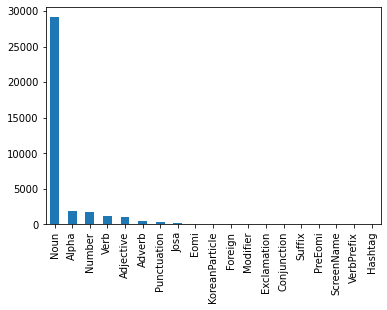

In [ ]:
pos_analysis_df['pos'].value_counts().plot(kind='bar')

## 5. 각 품사로 분류된 단어들 살펴보기(감탄사, 조사 등)

In [ ]:
pos_analysis_df[pos_analysis_df['pos'].map(lambda x : x in ['Josa', 'Eomi'])]

,word,count,pos
39,라고,4398,Josa
61,인데,3348,Josa
105,죠,2291,Josa
121,라,1969,Josa
148,이랑,1690,Josa
...,...,...,...
35820,는다고,1,Eomi
35906,려다,1,Eomi
36029,라니깐,1,Josa
36130,에서처럼,1,Josa


In [ ]:
pos_analysis_df[pos_analysis_df['pos'].map(lambda x : x in ['KoreanParticle'])].head()

,word,count,pos
1303,ㅋㅋ,179,KoreanParticle
1589,ㅋㅋㅋ,138,KoreanParticle
1966,ㅇㅇ,105,KoreanParticle
2611,ㅠㅠ,73,KoreanParticle
2630,ㅋㅋㅋㅋ,73,KoreanParticle


In [ ]:
pos_analysis_df[pos_analysis_df['pos'].map(lambda x : x in ['Foreign','Modifier'])].head(15)

,word,count,pos
508,동,562,Modifier
648,즈,436,Modifier
765,일이,359,Modifier
1038,뭔,244,Modifier
1162,근,207,Modifier
1368,한다는,166,Modifier
1395,극,162,Modifier
1654,언,131,Modifier
1810,뒷,116,Modifier
1877,♡,111,Foreign


In [ ]:
pos_analysis_df[pos_analysis_df['pos'].map(lambda x : x in \
                                           ['Exclamation', 'Conjunction'])].head()

,word,count,pos
934,그렇다고,276,Conjunction
942,그니까,274,Conjunction
1830,오오,114,Exclamation
2383,플,82,Exclamation
2470,엉,79,Exclamation


In [ ]:
 pos_analysis_df[pos_analysis_df['pos'].map(lambda x : x in \
                                           ['Suffix', 'PreEomi', 'ScreenName', 'VerbPrefix'])].tail(10)

,word,count,pos
6608,겟,17,PreEomi
7402,셨,14,PreEomi
9532,켓,9,PreEomi
9773,놨,9,PreEomi
30093,(@bawipastabar,1,ScreenName
31803,@you,1,ScreenName
32393,@liwoo3073_foodie,1,ScreenName
32988,@sushi_,1,ScreenName
32989,(@sushi_,1,ScreenName
33230,(@perlen_official,1,ScreenName


위와 같이, Noun, verb, adjective, adverb가 아닌 품사에 해당하는 단어들은 식당 설명과 관련이 적기 때문에 **Noun, verb, adjective, adverb**에 대해서만 분석을 진행한다.

## 6. 토큰화 & 품사태깅한 결과 분석 🌟🌟

In [ ]:
pos_analysis_df = pos_analysis_df[pos_analysis_df['pos'].map(lambda x : x in \
                                                             ['Noun', 'Verb', 'Adjective', 'Adverb'])]

In [ ]:
pos_analysis_df.describe()

,count
count,31692.000000
mean,43.746624
std,348.809279
min,1.000000
25%,1.000000
50%,3.000000
75%,10.000000
max,28119.000000


In [ ]:
pos_analysis_df.to_csv('pos_analysis_df.csv', sep=';')

### **[명사]**

In [ ]:
pos_analysis_df[pos_analysis_df['pos'] == 'Noun'].head(20)

,word,count,pos
1,맛,17926,Noun
8,안,9059,Noun
9,수,9031,Noun
15,저,7532,Noun
18,고기,6908,Noun
22,생각,6347,Noun
23,느낌,5926,Noun
24,인,5715,Noun
26,번,5435,Noun
28,내,5275,Noun


명사로 분류된 것도, 실제 쓰임에서는 부사로 쓰이는 것들이 존재했다. 예를들어 '진짜'의 경우 '진짜로 맛있다' 로 쓰이는 경우가 많기 때문에 수집한 자막 데이터들에서는 부사로 쓰일 것이다. 이 외에도 '살짝', '조금' 도 마찬가지로  이후 처리가 필요해보인다. 

In [ ]:
noun_df = pos_analysis_df[pos_analysis_df['pos'] == 'Noun']
noun_df.to_csv('noun_df.csv', sep = ';')

더 살펴본 결과, **메뉴 이름이나 재료 이름** 으로 분리된 경우가 많았다. 이후, 메뉴 이름을 추출할 때 사용할 수 있을 것으로 보인다.  

또한, 등장 빈도수가 높은 단어들 위주로 해당 단어들이 자막 내에서 어떻게 쓰이고 있는지를 살펴본 뒤 각 단어들을 다음과 같이 분류하였다.   


- **식당 관련 표현**  
'쫄깃', '바삭', '감칠맛', '매력', '상큼', '호불호', '두툼', '정감', '힐링', '최고급', '꼬들꼬들', '최애',... *(대체적으로 주관적인 의견을 담은 표현들)*

- **의견은 아니지만, 식당과 관련된 표현**  
'한정판', '혼술', '기념일', '송년회', '점심식사', '대학생', '썸녀', '여자친구', '남자친구', '비즈니스', '미팅' ....

- **식당 관련 정보가 나오는 문장임을 알 수 있게 해주는 단어**  
 '메뉴판', '분위기', '서비스', '인테리어', '내부', '접근', '접근성', '주차장', '주차', '주차공간', '발렛비', '포장', '리필' ...


- **식당 종류 / 카테고리**  
'선술집', '주점', '무한리필', '레스토랑', '일식집', '중식', '한식', '한정식' ...

### **[동사]**

In [ ]:
pos_analysis_df[pos_analysis_df['pos'] == 'Verb'][35:70]

,word,count,pos
211,놓다,1223,Verb
221,대다,1182,Verb
228,서다,1148,Verb
231,올라가다,1139,Verb
237,즐기다,1118,Verb
246,싸다,1086,Verb
265,줄다,1024,Verb
266,이라,1023,Verb
267,감다,1019,Verb
271,타다,1009,Verb


In [ ]:
verb_df = pos_analysis_df[pos_analysis_df['pos'] == 'Verb']
verb_df.to_csv('verb_df.csv', sep = ';')

명사와 마찬가지로 동사로 분류된 단어들에 대해서 해당 단어들이 자막 내에서 어떻게 쓰이고 있는지를 살펴본 뒤 각 단어들을 다음과 같이 분류하였다.  

- **조리 방식**  
튀기다, 익히다, 맵다, 굽다, 끓이다, 삶다

- **맛 관련 표현**  
맵다, 달다, 곁들이다, 좋아지다(곁들이니 맛이 좋아진다 등등), 녹다, 어우러지다, 끌리다, 꽂히다, 빛나다, 아삭거리다, 미끌거리다, 어우르다, 차가워지다, 춤추다(입안에서 춤춘다), 푸석거리다, 맴돌다, 꽉차다, 오독거리다, 어울리다..

- **분위기/서비스 관련 표현**  
여유롭다, 대접받다..

- **식당에 대한 점수를 내는 데 적합한 표현**  
인정받다, 사랑받다, 잘나가다, 뽐내다, 간지나다, 춤추다(입안에서 춤춘다 등등), 화나다, 잘해주다, 대접받다...

### **[형용사]**

In [ ]:
pos_analysis_df[pos_analysis_df['pos'] == 'Adjective'].head(15)

,word,count,pos
3,좋다,13703,Adjective
5,맛있다,10305,Adjective
11,아니다,8429,Adjective
12,없다,8311,Adjective
25,많다,5606,Adjective
62,굉장하다,3320,Adjective
67,좋아하다,3112,Adjective
78,부드럽다,2865,Adjective
82,어떻다,2788,Adjective
115,아깝다,2064,Adjective


In [ ]:
adjective_df = pos_analysis_df[pos_analysis_df['pos'] == 'Adjective']
adjective_df.to_csv('adjective_df.csv', sep = ';')

형용사로 분류된 단어들은 명사나 동사에 비해 사용 가능한 단어들이 훨씬 많았다. 형용사로 분류된 단어들에 대해서 해당 단어들이 자막 내에서 어떻게 쓰이고 있는지를 살펴본 뒤 몇 단어들을 다음과 같이 분류하였다. 어떤 문장에서 쓰이는가에 따라 카테고리가 달라지는 경우가 많았다. 

<br>

- **맛/음식 관련 표현**  
많다,맛있다, 부드럽다, 강하다, 고소하다, 적당하다,  쎄다(간이 쎄다), 특이하다,  깔끔하다,  다양하다, 촉촉하다, 담백하다, 충분하다, 느끼하다, 특별하다, 시원하다, 독특하다, 따뜻하다, 재밌다, 차갑다, 간단하다, 두껍다, 새롭다, 야들야들하다, 통통하다, 도톰하다, 화려하다, 애매해다, 진하다, 익숙하다, 은은하다, 부족하다, 달콤하다, 신선하다

<br>

- **분위기/가격/위생 관련 표현**  
 비싸다, 높다(가격, 수준), 저렴하다, 깔끔하다, 정갈하다, 더럽다, 화려하다, 편안하다, 즐겁다, 고급스럽다, 넓다, 편하다, 빠르다, 가깝다, 친절하다

<br>

- **식당에 대한 점수를 내는 데 적합한 표현**  
유명하다, 괜찮다, 좋다, 굉장하다, 좋아하다, 엄청나다, 나쁘다, 만족스럽다, 싫어하다, 완벽하다, 맛있다, 많다, 굉장하다, 상당하다, 만족하다, 멋지다,  실망하다,



### **[부사]**

In [ ]:
pos_analysis_df[pos_analysis_df['pos'] == 'Adverb'].head(15)

,word,count,pos
17,많이,6915,Adverb
20,너무,6709,Adverb
79,엄청,2862,Adverb
125,되게,1940,Adverb
183,없이,1424,Adverb
191,씩,1356,Adverb
214,따로,1213,Adverb
253,훨씬,1058,Adverb
401,우,694,Adverb
403,특히,693,Adverb


In [ ]:
adverb_df = pos_analysis_df[pos_analysis_df['pos'] == 'Adverb']
adverb_df.to_csv('adverb_df.csv', sep = ';')

부사의 경우, 맛이나 식당에 대한 평가 앞에 꾸며주는 말로 쓰기도 하지만, 습관적으로 쓰는 말들이나 식당 소개를 전개해나가는 과정에서 쓰이는 경우가 많았다. '많이', '천천히', '엄청', '훨씬' 등의 표현들은 다른 상황에서 쓰이는 경우가 많기 때문에 이러한 단어들은 사용이 어려울 것이라 판단했다.   

<br> 
- 아삭아삭, 탱글탱글, 오독오독, 포슬포슬, 꾸덕꾸덕, 바삭바삭, 바사삭, 호로록, 폭신폭신, 몽글몽글, 찐득찐득, 몰캉몰캉, 수북이, 꼬독꼬독..

위와 같은 단어들의 종류가 다양했으며, 주로 맛을 표현할 때 쓰이는 단어들이었다. 유튜버들마다, 영상들마다 표현들이 가지각색이라 위와 같은 단어들의 등장 빈도수는 대체적으로 낮은 편이었다.   

## 7. 요약 및 계획 🌟🌟

### 전처리
- `soyspacing`으로 띄어쓰기 전처리를 하려 했지만, 도메인에 알맞는 학습 데이터가 존재하지 않아서 `pykospacing`을 이용하기로 함(pykospacing은 학습된 모델로, 뉴스 데이터에서 띄어쓰기를 학습. 띄어쓰기가 난장판인 경우 볼만한 문서로 바꾸는데 유용함)

- `pykospacing`으로 띄어쓰기 전처리했을 때, 붙어있어야 하는 단어인데 띄어져있는 경우에는 처리하지 못함. 

- 특히, 자동생성자막의 경우 띄어쓰기 전처리가 어려워서 토큰화가 잘 이루어지지 않는 경우가 있음.(쫀 득쫀득, 쫀 득쫀 득, 쫄 깃쫄깃 등..)

- 자동 생성 자막인 경우, 문장의 띄어쓰기를 다 없앤 다음에 `pykospacing`을 적용해서 토큰화가 잘 이루어질 수 있는지 실험해볼 계획임.

- 💡 토큰화한 단어 목록을 통해, 직접 전처리할 수 있는 것들은 미리 처리할 계획. 신조어처럼 토큰화되어 나뉘어지면 안되는 단어들(갓성비..) 도 처리할 계획.    
ex) 새 콤달콤 -> 새콤달콤/ 쫄 깃쫄깃, 깃쫄깃 -> 쫄깃쫄깃/ 베뉴 -> 메뉴, 갓 성비 -> 갓성비 / 다 성비 -> 가성비

<br><br>

### 토큰화
- `konlpy` 의 `Okt` 를 사용하여 토큰화 및 품사 분석을 진행함. 현재 단계에서는, 단어를 꺼내와서 어떤 품사인지 파악하는 것으로 했지만 차후에는 문맥 내에서 어떤 품사인지 태깅하는 방식을 적용할 수 있을 것임.

- 품사를 태깅해보기 전에 토큰화된 단어들 중에서 쓸 수 있을만한 단어들 1175개를 뽑아보는 작업을 진행했음. (지금은 품사 태깅을 마쳤으므로, 품사 태깅 column을 추가하면 될 것 같다!)

- 명사, 동사, 형용사, 부사 별로 어떤 키워드를 뽑아낼 수 있을지 확인하는 과정.

- 💡 동사, 명사, 형용사, 부사가 아닌 품사들에 대해서 제거를 진행할지 고민해볼것.

- 💡 불용어사전 재정의 필요.

<br><br>

### 분류 🌟🌟
- 맛에 대한 주관적인 표현들은 한정적이기 때문에, 국립 국어원 맛 표현들을 지금 단계에서 사용할 필요가 있을지?  

- 💡 크게 **키워드**(사용자에게 표시할 키워드), **평가**(사용자에게 표시하지는 않지만, 리뷰 점수를 매기는 데 사용할 단어) 로 나눌 계획.  
소분류는 최대한 자세히 나눌 것. 나중에 합치더라도 일단 세세하게 나눌것.

|대분류|소분류|비고|
|-----------|-----------|-----------|
|키워드|맛|감칠맛, 식감, ..|
|     |분위기|고급스러운, 데이트 ..|
|     |가격|가성비, 저렴한, 비싼|
|     |서비스|친절한|
|     |청결|더러운, 깨끗한, 깔끔한|
|     |메뉴|메뉴 이름들|
|     |INFO|필요한 정보들인데 위에 속하지 않는 경우; 메뉴판, 주차장..|
|     |기타|키워드로 사용할만 하지만 위에 해당 안될 경우. 모르겠는 경우|
|평가|평가등급|훌륭하다, 만족하다, 좋다, 실망하다.. 각 단어별 점수는 차후에 매길것|

<br><br>

### 분류 이후 계획 🌟🌟
- |자막시간 |자막문장 |문장토큰화결과(단어/품사/소분류카테고리)|토큰화결과직접보정(단어/품사/소분류카테고리)


|자막시간|자막문장|문장 토큰화 결과|직접 보정|
|-----------|-----------|-----------|--------|
|생략|김치가 들어가 있어서 깔끔한 맛이 너무 좋았습니다|[(김치, 'Noun', ['메뉴']), (깔끔하다, 'Adj', ['맛','청결']), (좋다, 'Adj', ['평가-A'])]|[(깔끔하다, 'Adj', ['맛']), (좋다, 'Adj', ['평가-A'])]|



> 깔끔하다 라는 단어가 청결, 맛에 해당될 수 있는데 이 문장에서는 맛에 해당되는 것이므로 마지막 column에 '맛'만 남겨두기. '김치'라는 단어가 식당을 표현하는 데 크게 도움이 되지 않는 정보라면 생략.



- 위와 같이 토큰화한 결과가 해당 문장 안에서 올바른 카테고리인지, 필요한 키워드인지 확인하여 보정하는 작업을 진행할 예정.

- 보정한 결과를 이용해 학습 데이터를 만들어서 딥러닝을 적용해볼 예정임.


<br><br>


